In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings


In [2]:
class FaceFolderDataset(Dataset):
    def __init__(self, root_dir, images_limit=16, dirs=None):
        self.images_limit = images_limit
        self.root_dir = root_dir
        self.person_images = {int(person): [] for person in os.listdir(root_dir)}
        self.persons = sorted(os.listdir(root_dir))
        if dirs is not None:
            for p in self.persons:
                if p not in dirs:
                    self.persons.remove(p)
        self.person_to_idx = {person: index for index, person in enumerate(self.persons)}
        self.person_indexes = []
        self.image_paths = []

        for i, c in enumerate(self.persons):
            pearson_dir = os.path.join(self.root_dir, c)
            for file_name in os.listdir(pearson_dir):
                if file_name not in [f"{idx}.png" for idx in range(images_limit)]:
                    continue
                self.image_paths.append(os.path.join(pearson_dir, file_name))
                self.person_images[int(c)].append(os.path.join(pearson_dir, file_name))


    def __getitem__(self, index: int)-> list[torch.Tensor]:
        person = self.persons[index]
        person_image_paths = self.person_images[int(person)]
        result_images = []
        for image_path in person_image_paths:
            if not image_path.endswith(".png"):
                warnings.warn(f"Image {image_path} is not a png file")
                continue
            image = Image.open(image_path)
            image = image.convert("RGB")
            image = transforms.ToTensor()(image)
            if image.shape != (3, 112, 112):
                raise ValueError(f"Image {image_path} has shape {image.shape} instead of (3, 112, 112)")
            result_images.append(image)
        return result_images


    def get_person_images(self, person: str, limit=None)-> list[torch.Tensor]:
        if (limit is not None) and (limit > self.images_limit):
            warnings.warn(f"Limit {limit} is greater than images limit {self.images_limit} (numbers of photos im one folder)")
        person_image_paths = self.person_images[int(person)]
        np.random.shuffle(person_image_paths)
        result_images = []
        for image_path in person_image_paths:
            if not image_path.endswith(".png"):
                warnings.warn(f"Image {image_path} is not a png file")
                continue
            image = Image.open(image_path)
            image = image.convert("RGB")
            image = transforms.ToTensor()(image)
            if image.shape != (3, 112, 112):
                raise ValueError(f"Image {image_path} has shape {image.shape} instead of (3, 112, 112)")
            result_images.append(image)
            if limit is not None and len(result_images) >= limit:
                break
        return result_images


    def __len__(self):
        return len(self.persons)

In [3]:
import itertools


class FaceDataLoader:
    def __init__(self, face_dataset: FaceFolderDataset, shuffle=False, num_workers=0, batch_size=8):
        self.dataset: FaceFolderDataset = face_dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers


    def __iter__(self)-> torch.Tensor:
        for _ in range(len(self.dataset) // self.batch_size):
            res = torch.zeros([3 * self.batch_size, 3, 112, 112], dtype=torch.float32)
            for i in range(self.batch_size):
                im11, im12, im21 = self.get_triple()
                res[3 * i] = im11
                res[3 * i + 1] = im12
                res[3 * i + 2] = im21
            yield res

    def iter_same_person_batch(self, batch_size: int)-> torch.Tensor:
        persons = self.dataset.persons
        random.shuffle(persons)
        for person in persons:
            images = self.dataset.get_person_images(person, limit=batch_size)
            yield torch.stack(images)

    def iter_different_person_batch(self, batch_size: int)-> torch.Tensor:
        # iter for person in all avalibale batch_size length persons combinations
        for persons in itertools.combinations(self.dataset.persons, batch_size):
            images = []
            for person in persons:
                images.append(random.choice(self.dataset.get_person_images(person, limit=1)))
            yield torch.stack(images)


    def get_triple(self)-> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        p1, p2 = np.random.choice(self.dataset.persons, 2, replace=False)
        p1_images: list = self.dataset.get_person_images(p1, limit=2)
        p2_images: list = self.dataset.get_person_images(p2, limit=1)
        # Add extra dim for batch for all images
        return torch.unsqueeze(p1_images[0], 0), torch.unsqueeze(p1_images[1], 0), torch.unsqueeze(p2_images[0], 0)

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [44]:
import torch

# Создаем датасет
 # TODO something wrong with images limits
images_limit = 20
test_dataset = FaceFolderDataset('images', images_limit=images_limit, dirs=[str(i) for i in range(12)])
train_dataset = FaceFolderDataset('images', images_limit=images_limit, dirs=[str(i) for i in range(12, 4000)])
# Создаем загрузчик данных
dataloader = FaceDataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = FaceDataLoader(test_dataset, shuffle=True)

Check if dataloaaders work corrcetly and dataset is correct (images from same person are similar)

torch.Size([1, 3, 112, 112]) torch.Size([1, 3, 112, 112]) torch.Size([1, 3, 112, 112])


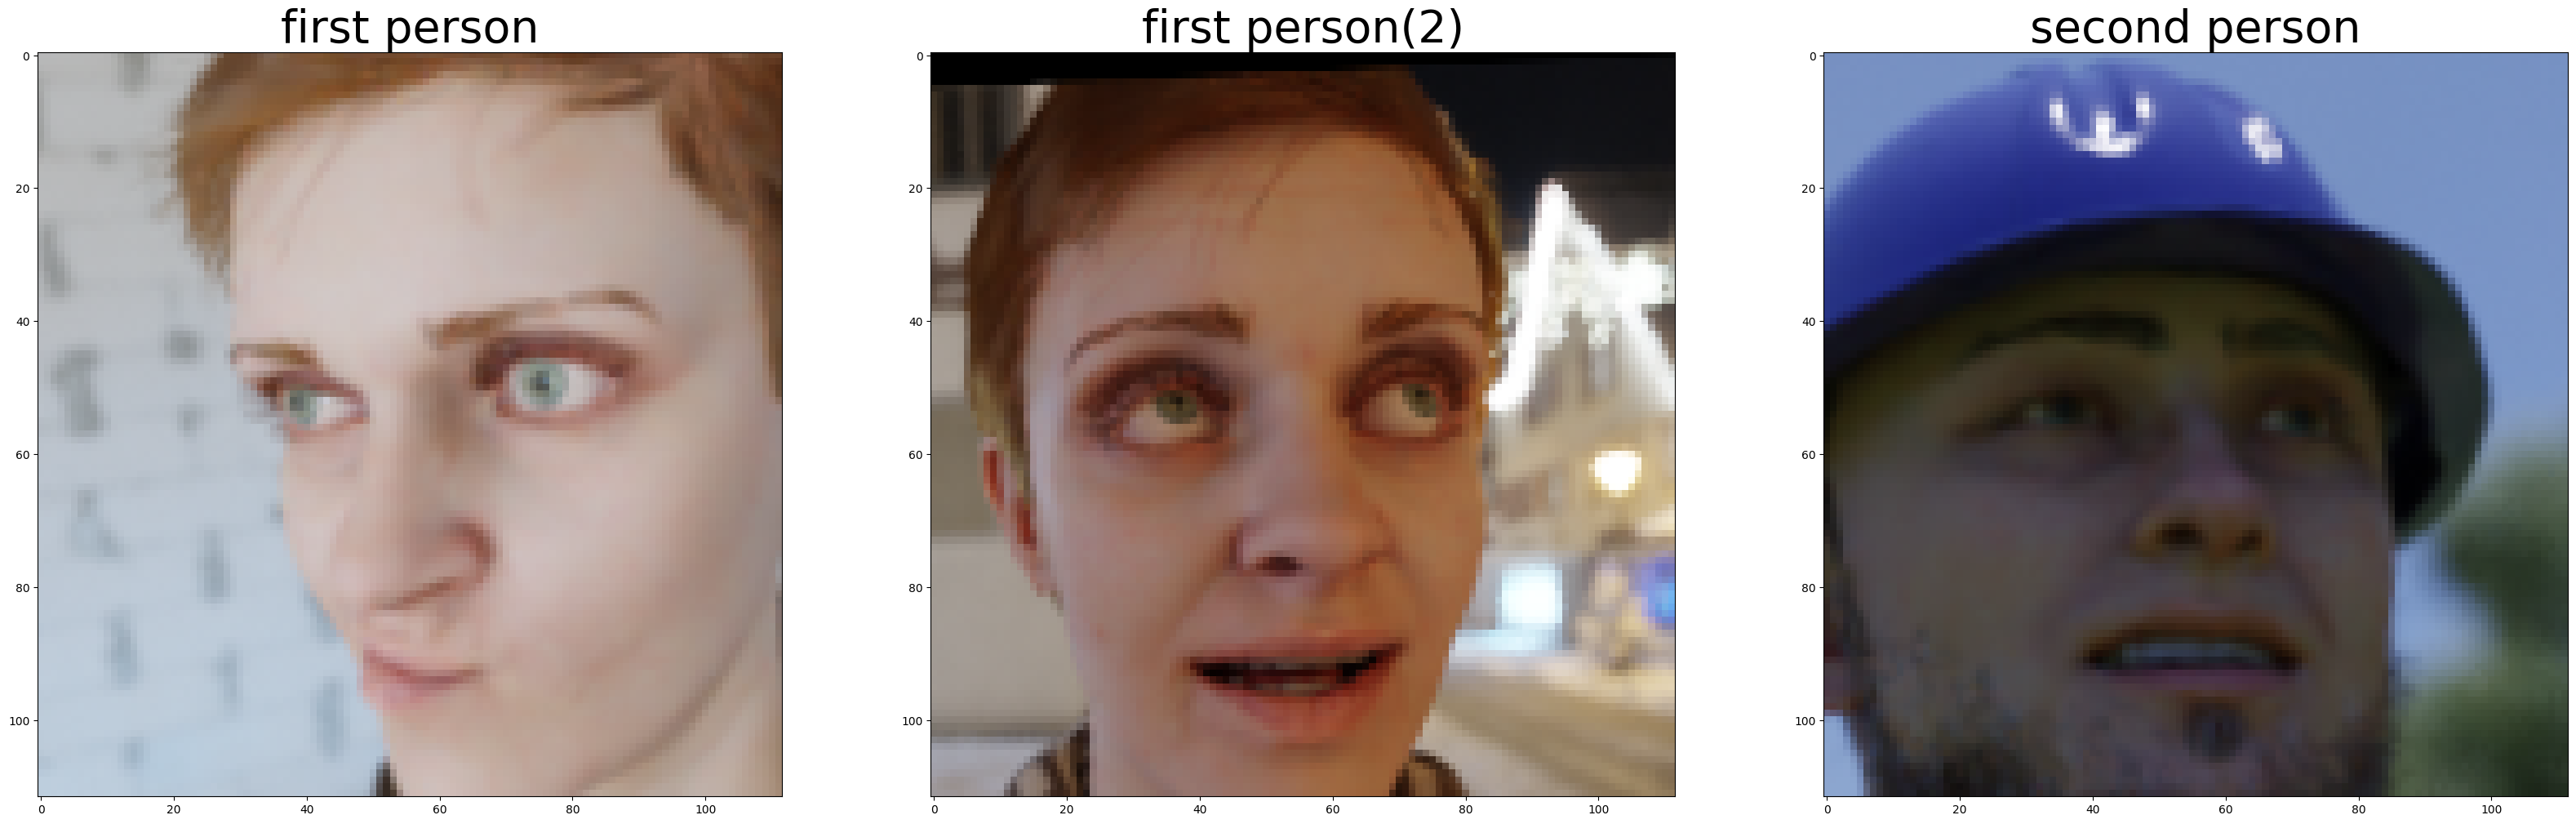

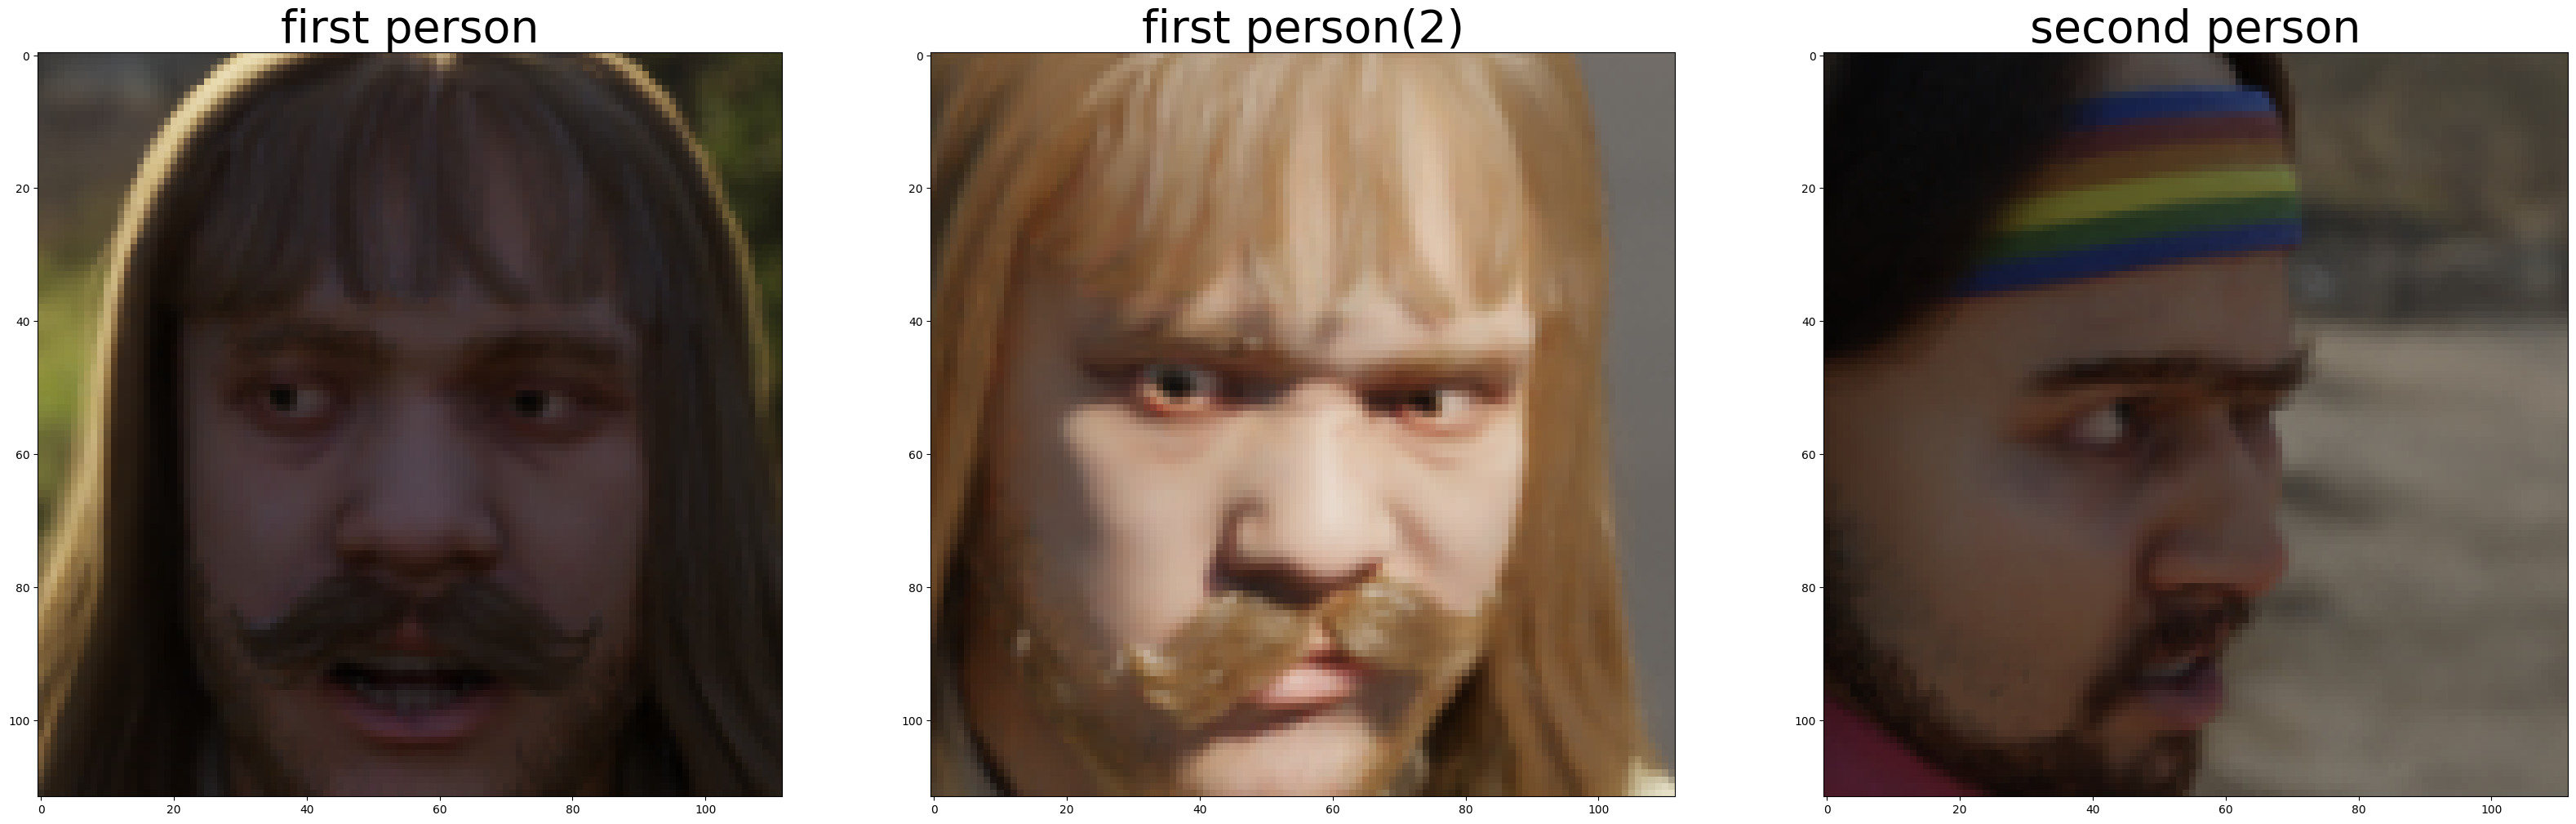

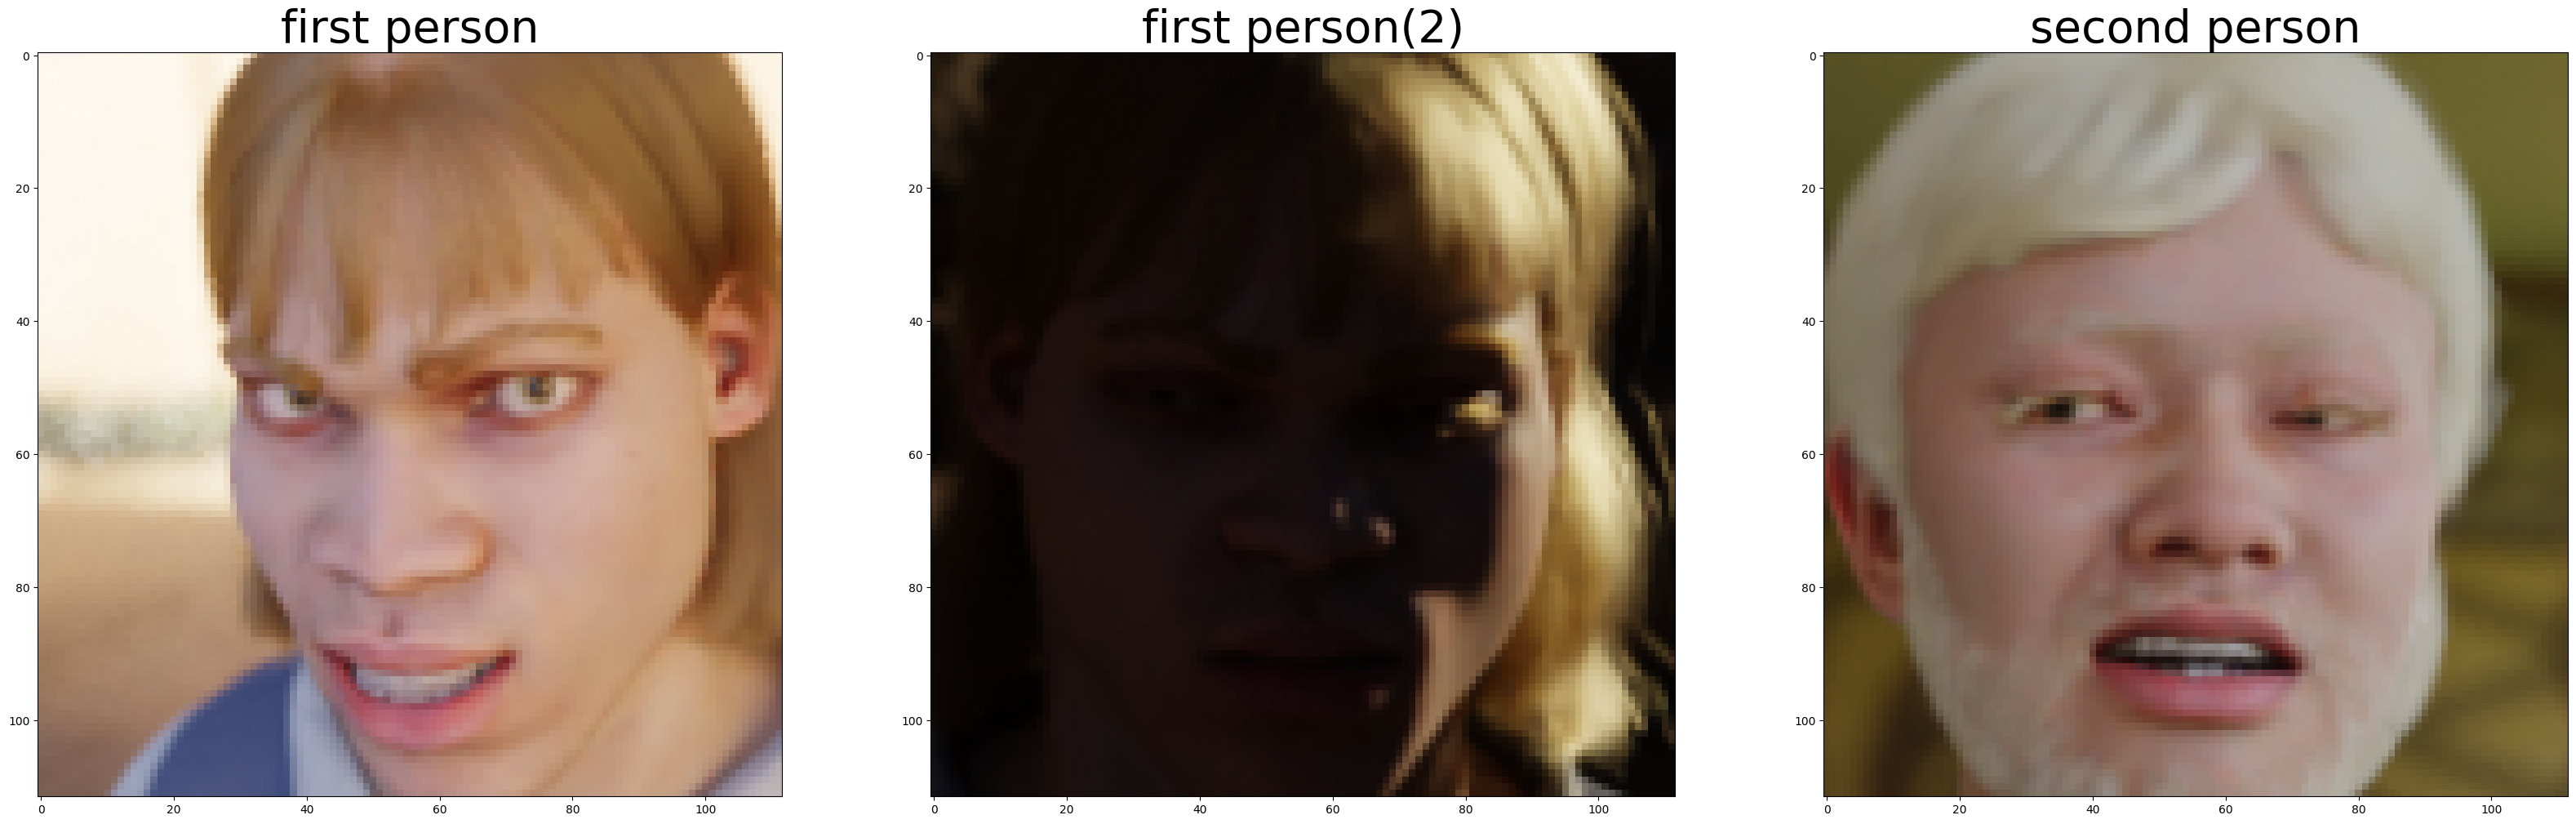

In [5]:
im11, im12, im21 = dataloader.get_triple()
print(im11.shape, im12.shape, im21.shape)
for _ in range(3):
    im11, im12, im21 = dataloader.get_triple()
    im11 = im11[0]
    im12 = im12[0]
    im21 = im21[0]
    fig = plt.figure(figsize=(40, 40))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(im11.permute(1, 2, 0).numpy())
    ax1.set_title("first person")
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(im12.permute(1, 2, 0).numpy())
    ax2.set_title("first person(2)")
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(im21.permute(1, 2, 0).numpy())
    ax3.set_title("second person")

    for ax in fig.axes:
        ax.title.set_fontsize(40)
    plt.show()

In [6]:
model = nn.Sequential( # Input image size = 112 x 112
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 56 x 56
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 28 x 28
    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(),
    nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(48 * 28 * 28, 4096),
    nn.ReLU(),
    nn.Linear(4096, 128),
    nn.ReLU()
)
device = torch.device('cuda')
model = model.to(device)


In [7]:
# Use torchsummary to check model memory usage
import torchsummary as ts
ts.summary(model, (3, 112, 112), batch_size=72, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [72, 32, 112, 112]             896
       BatchNorm2d-2         [72, 32, 112, 112]              64
              ReLU-3         [72, 32, 112, 112]               0
         MaxPool2d-4           [72, 32, 56, 56]               0
            Conv2d-5           [72, 32, 56, 56]           9,248
       BatchNorm2d-6           [72, 32, 56, 56]              64
              ReLU-7           [72, 32, 56, 56]               0
         MaxPool2d-8           [72, 32, 28, 28]               0
            Conv2d-9           [72, 48, 28, 28]          13,872
      BatchNorm2d-10           [72, 48, 28, 28]              96
             ReLU-11           [72, 48, 28, 28]               0
           Conv2d-12           [72, 48, 28, 28]          20,784
      BatchNorm2d-13           [72, 48, 28, 28]              96
             ReLU-14           [72, 48,

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
class Logger:
    def __init__(self):
        self.losses = []
        self.sim_losses = []
        self.diff_losses = []

    def log_loss(self, loss: torch.Tensor, sim_loss: torch.Tensor, diff_loss: torch.Tensor):
        self.losses.append(loss.item())
        self.sim_losses.append(sim_loss.item())
        self.diff_losses.append(diff_loss.item())


In [32]:
import random
def loss_fn(sim: tuple[torch.Tensor, torch.Tensor], diff: torch.Tensor, logger: Logger, alpha=1, beta=1)-> torch.Tensor:
    """
    :param sim: tuple of two vectors (Torch.Tensor[1, 128]) from same person
    :param diff: vector (Torch.Tensor[1, 128]) from different person
    :param alpha: weight for same person loss
    :param beta: weight for different person loss
    :param logger: Logger object to log loss
    :return: torch.Tensor[1] - loss
    """
    # Normalise input vectors
    sim = [torch.nn.functional.normalize(v, dim=1) for v in sim]
    diff = torch.nn.functional.normalize(diff, dim=1)
    # Calculate loss
    sim_los = torch.nn.functional.cosine_similarity(sim[0], sim[1], dim=1).mean()
    diff_loss = torch.nn.functional.cosine_similarity(sim[0], diff, dim=1).mean() + torch.nn.functional.cosine_similarity(sim[1], diff, dim=1).mean() # TODO think about it
    loss = alpha * sim_los - beta * diff_loss
    logger.log_loss(loss, sim_los, diff_loss)
    return -loss # Тут стоит минус потому что косинусоидальное расстояние для одинаковых обьектов - 0, а для разных - +\- 1, а нам нужно наоборот

In [45]:
from tqdm.notebook import tqdm
log = Logger()
num_epochs = 25

print("Start training")
for epoch in tqdm(range(num_epochs)):
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        model.train()
        batch = batch.to("cuda")
        emb = model(batch)
        sim = emb[::3], emb[1::3]
        diff = emb[2::3]
        loss = loss_fn(sim, diff, logger=log)
        loss.backward()
        optimizer.step()


    print(f"Epoch {epoch} loss: {loss.item()}")




Start training


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 0 loss: 0.2146572470664978


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 loss: 0.04895573854446411


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 loss: 0.10022461414337158


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3 loss: -0.011386513710021973


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 loss: -0.07243207097053528


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 loss: -0.059819310903549194


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6 loss: -0.07391072064638138


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 loss: -0.09981207549571991


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 loss: -0.056535735726356506


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9 loss: -0.01570156216621399


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10 loss: 0.0050104036927223206


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 loss: -0.030244991183280945


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12 loss: -0.0026476234197616577


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 loss: -0.1276848316192627


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14 loss: 0.0239485502243042


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15 loss: -0.05384829640388489


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 16 loss: -0.11537618190050125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 17 loss: 0.00462380051612854


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 18 loss: -0.072797991335392


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 19 loss: 0.014259874820709229


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 20 loss: -0.052452150732278824


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 21 loss: 0.035009339451789856


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 22 loss: -0.007864922285079956


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 23 loss: -0.01997402310371399


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 24 loss: -0.008089661598205566


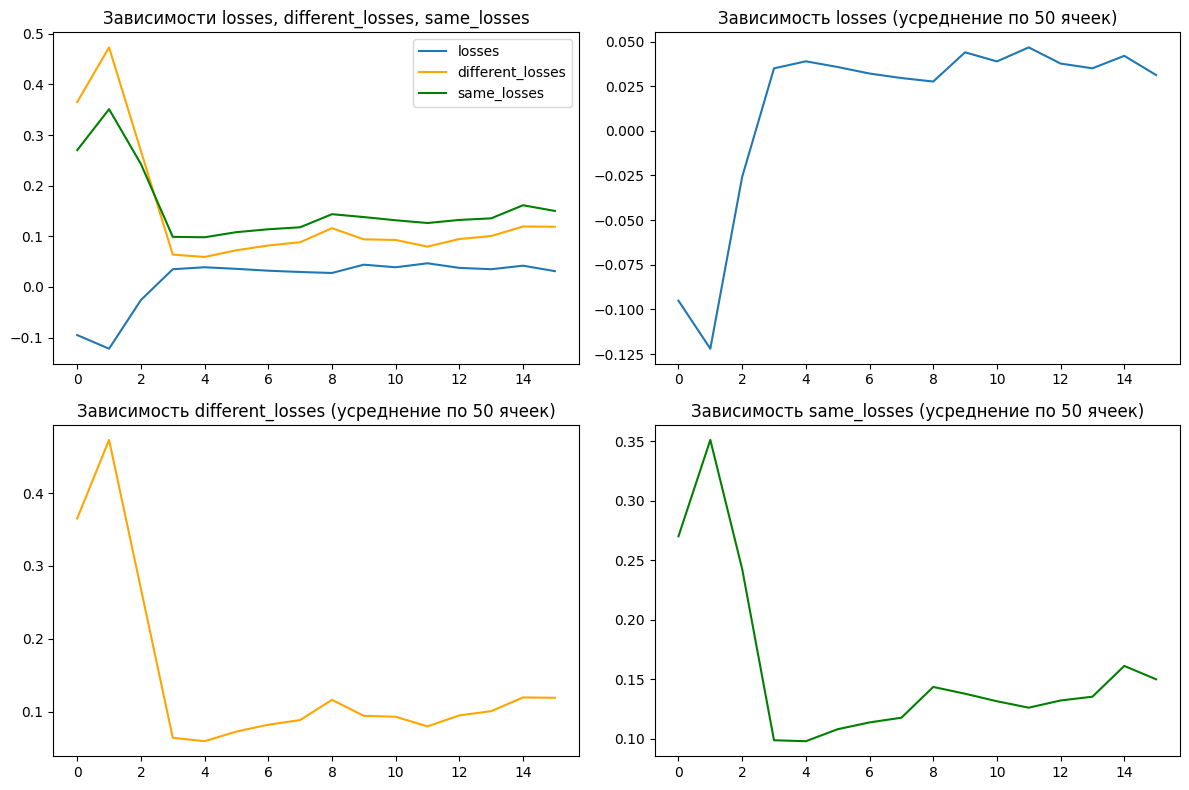

In [46]:
# Усредняем каждые 50 ячеек
losses, different_losses, same_losses = log.losses, log.diff_losses, log.sim_losses
N = len(losses)
losses_avg = [np.mean(losses[i:i+50]) for i in range(0, N, 50)]
different_losses_avg = [np.mean(different_losses[i:i+50]) for i in range(0, N, 50)]
same_losses_avg = [np.mean(same_losses[i:i+50]) for i in range(0, N, 50)]

# Создаем фигуру и оси графиков
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Зависимости losses, different_losses, same_losses от индекса на одном графике
axs[0, 0].plot(losses_avg, label='losses')
axs[0, 0].plot(different_losses_avg, color='orange', label='different_losses')
axs[0, 0].plot(same_losses_avg, color='green', label='same_losses')
axs[0, 0].set_title('Зависимости losses, different_losses, same_losses')
axs[0, 0].legend()

# Зависимость losses от индекса
axs[0, 1].plot(losses_avg)
axs[0, 1].set_title('Зависимость losses (усреднение по 50 ячеек)')

# Зависимость different_losses от индекса
axs[1, 0].plot(different_losses_avg, color='orange')
axs[1, 0].set_title('Зависимость different_losses (усреднение по 50 ячеек)')

# Зависимость same_losses от индекса
axs[1, 1].plot(same_losses_avg, color='green')
axs[1, 1].set_title('Зависимость same_losses (усреднение по 50 ячеек)')

# Отображаем графики
plt.tight_layout()
plt.show()

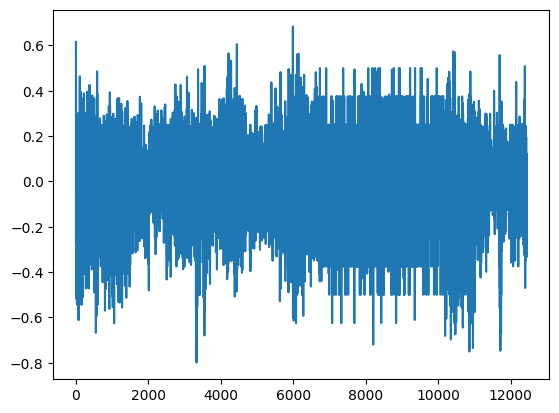

In [43]:
plt.plot(losses, label='losses')

Text(0.5, 0, 'Loss(epoch)')

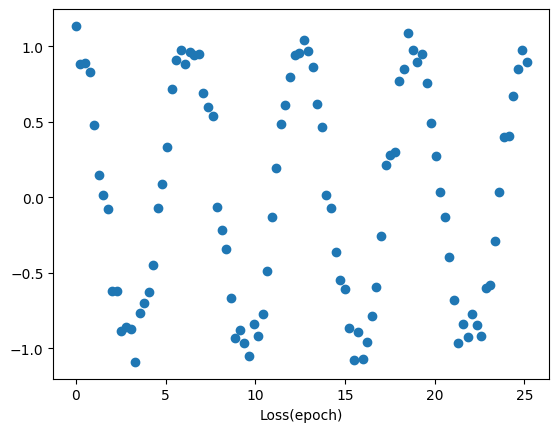

In [42]:
# Generate cos(x) with noise
x = np.linspace(0, 8 * np.pi, 100)
y = np.cos(x) + np.random.normal(0, 0.1, 100)
plt.plot(x, y, 'o')
plt.xlabel('Loss(epoch)')

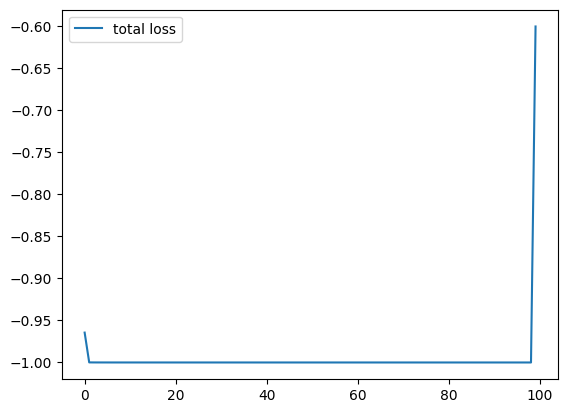

In [15]:
plt.plot([sum(losses[i:i+10])/10 for i in range(0, len(losses), 10)], label='total loss')
plt.legend()
plt.show()

In [16]:
plt.plot([sum(test_losses[i:i+10])/10 for i in range(0, len(test_losses), 10)], label='total loss')
# plt.plot(test_different_losses, label='different loss')
# plt.plot(test_same_losses, label='same loss')
plt.show()

NameError: name 'test_losses' is not defined